In [3]:
%matplotlib inline
from datascience import *
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import display, Markdown
from sklearn.metrics import classification_report
import pandas as pd
plt.rcParams['figure.figsize'] = [8, 8]
plt.rcParams.update({'font.size': 18})

# Machine Learning Analysis: Bounding the Nearest Neighbors Algorithm
>## Establish a Radius of Convergence using Chebyshev's Theorem

Using a specified mathematical model, and/or quantitative information from a dataset, known as $features$, we can build a machine learning algorithm to classify a new item/datapoint with similar features. 

In this build, we will implement the classification first with the distance formula and then increase our accuracy by implementing more features. 

Firstly, we must establish the proper proportions from our dataset and split our dataset into two groups based on those proportions. It is important to note that before splitting the data, we must split the ratios randomly. So we will accomplish this by sampling our table without replacement (to preserve the characteristics of data).

It is important to note that it is best to standardize all values in the dataset first! Since all values within the table may not scale the same, the distance between points will be skewed in the direction of the axis that has a higher magnitude. 

Therefore, we can standardize the dataset by the standardization formula which centers the data by the mean and scales all coordinates on their corresponding axis by their Standard Deviation Thus, $$ Z_{su}[x] = \dfrac{[x] - avg[x]}{\sigma_{sd}[x]} $$ 

where $\sigma$ is the Standard Deviation for an input vector $[x]$ which can be denoted by 
$$\sigma_{sd}[x] = \sqrt{avg([x] - avg[x])^2} .$$ 

The standard deviation can be summarized as the root mean square error of all deviations away from the corresponding average(RMSE).

# Theory Craft: Radius Sort

The main demonstration of this project is to make the computation time of the Nearest Neighbors(KNN) Algorithm more efficient. To accomplish this, implementing the KNN using a "radius of convergence" approach to solve this problem. Since the underlying property of the nearest neighbors algorithm, classifies or numerically produces a result through similar numerical results the results produced by the algorithm are clustered around similar point values. Since this is the case, the farthest points do not have an impact on the classification of the algorithm. Therefore, the distance values can be filtered by converting the data table to standard units and reference the standardized values with respect to the unknown data vector to establish a circular boundary from the unknown point. Therefore, a distance from the unknown data vector and an arbitrary point from the training set will create a circle that will contain points within this boundary. This leads to computing the points within the area of the circle. Thus, the computation time will be significantly reduced. 

The next approach is to address the issue of deciding on a boundary point to establish a radius $R$ that will enclose the potential points of interest. One approach is to use the average value and computing the distance between the unknown data vector and the mean of the features. This will establish the boundary close to the majority of the points.

Even though data points have been filtered since the cluster of points will be the only points of interest, there is some control over determining how many data points are found in this "radius of convergence." To filter the amount of data found in this radius, the table can be filtered using the [Chebyshev Theorem](https://en.wikipedia.org/wiki/Chebyshev%27s_inequality). Since Chebyshev Theorem does not depend on the type of distribution the data may have, the max error bounds specified by the Chebyshev Theorem can be applied to the training table. As a result, the radius $R$ will be established with approximately 50% to 66.6% of the data contained in the training set.

Using Chebyshev's Theorem is a valid operation on the KNN Algorithm since the results produced by KNN is dependent on the number of points in the local neighborhood of the unclassified data vector. Therefore, the only constraint on the usage of Chebyshev's Theorem is to preserve the optimal value(s) of $K$ to properly determine how many points are required to classify or numerically compute the results. Since this process is determined by the characteristics displayed by the majority of local values relative to the unclassified point, using Chebyshev's Theorem to constrain the points within the bounded radius of convergence will contain the crucial points that are required to accurately classify or numerically compute the proper results produced by the KNN Algorithm.

In [4]:
def split_dataset(table):
    """This funtion takes in a table that splits the table into two subtables: 
        training table and test table by randomly sampling the rows."""
    # using 80 train_set : 20 test_set
    train_prop = int(0.8 * table.num_rows)
    test_prop = int(0.2 * table.num_rows)
    shuffle_data = table.sample(with_replacement = False) # could implement this with np.random.choice in order to not use data8 package
    train_set = shuffle_data.take(np.arange(0, train_prop))
    test_set = shuffle_data.take(np.arange(train_prop, table.num_rows))
    return [train_set, test_set]

# selectors
def train_table(split_tables):
    return split_tables[0]
def test_table(split_tables):
    return split_tables[1]

The default implementation of the KNN algorithm is computing the Euclidean Distance between the unclassified data array and the features array. 

Since we are dealing with arrays, the distance formula will be applied to each element in the training array relative to the unknown classification array. Thus, 

$$F([X_{unknown}],[Y_{train}]) = \sqrt{\sum\Delta(x, y)^2}$$

# Modifying the Distance Metric: Inner Products

In this implementation of Kth Nearest Neighbors, there are a few other functions available in an attempt to increase the accuracy of the algorithm. The commonly used functions are in the function list below. However, there is one function that requires a highlight: Inner Product.

The inner product can be described as 

$$<[a],[b]> \, = len\left([a]\right)\, len([b])\, cos(\theta).$$

However, the interesting property that will be implemented for the Nearest Neighbors Algorightm is the $cosine$ angle between two vectors. Specifically: 

$$ \theta = arcos\left( \dfrac{<[a],[b]>}{len[a]\, len[b]}\right).$$

Therefore, angle produced between two vectors can be interpreted as a scalar value

A geometric understanding of interpreting the angular relationship between two vectors is that when two vectors have an angle of zero, the cosine of that angle is one. Conversely, if two vectors have an angle of $\cfrac{\pi}{2},$ the cosine of that angle is zero. 

When taking the $arcos$ between the two vectors, everything between the edge cases will sway towards 0 or $\cfrac{\pi}{2}$ except at the midpoint $\cfrac{\pi}{4}$. 

The idea for using the $cosine$ in the Nearest Neighbors(KNN) goes as follows, since the property that KNN determines a result based on similar feature values, the cosine angle provides an implementation that is analogous to the KNN property by adding the constraint such that the directional relationship complements the results produced by the Euclidean Distance.

Since the notion that two vectors can be considered to have similar properties if the angle between them is 0, we use the angular value and multiply it with the distance value resulting from the Euclidean Distance. Since the goal of the KNN algorithm is to find a discrete number of points with the shortest distance, scaling the distance by the strength of cosine angle preserves this property. Conversely, if the cosine angle between two vectors is $\cfrac{\pi}{2}$, this leads to the maximum angle produced by cosine for our implementation. Consequently, when the max angle is scaled the distance value, the corresponding points are less likely to be considered a neighborly point to the point the KNN algorithm is trying to classify or numerically determine. Thus, this will preserve the assumption of the KNN algorithm uses similar values closest to the unclassified data vector.  

In [5]:
def euclid_distance(unknown_vector, train_vector):
    """This function takes in the unknown data vector and the training vector and returns the 
        Euclidean distance between each element within the two arrays."""
    distance = np.sqrt(np.sum( (unknown_vector - train_vector)**2 ))
    return distance

def cosine_angular_weights(unknown_vector, train_vector):
    """This function takes in the unknown data vector and the training vector and returns a 
        float that represents the cosine angle between the two vectors."""
    dot_product = np.sum(unknown_vector * train_vector)
    vector_length = np.sqrt(np.sum(unknown_vector**2)) * np.sqrt(np.sum(train_vector**2))
    if np.round(vector_length) == 0:
        return np.arccos(1)
    else:
        angular_weight = np.arccos(dot_product / vector_length)
        return angular_weight

def standardize_values(vector):
    """This function takes in a array and returns the standardized values 
        for each element in the array. 
        z = (val - mean(val)) / SD(val)."""
    return (vector - np.mean(vector)) / np.std(vector)
    
def data_normalization(vector):
    """This function normalizes data such that the min value is 0 and max value is 1 
        and all values fall within the min/max bounds. 
        V_norm = x - x_min / x_max - x_min."""
    vector_min, vector_max = np.min(vector), np.max(vector)
    return (vector - vector_min) / (vector_max - vector_min)

KNN is typically a classification machine learning algorithm. However, this implementation is modified to handle numerical results as well. The distance formula is used to compute the distance between all possible points. Afterward, the process requires a finite number of points that are closest to our desired data point in order to compute the average between the finite values classified as the shortest points relative to the unknown data vector. 

It is important to note that in the current build of $compute \, distance,$ it is unoptimized for lengthy computations.

In [6]:
def compute_features_distance(unknown_arr, train_tbl, features):
    """This function takes in a row of features and 
        computes the distances of all other values in the training table 
        and returns the appended distances on the training table. """
    distances = make_array()

    train_with_features = train_tbl.select(features)
    for row in np.arange(train_tbl.num_rows):
        feature_row, train_row = unknown_arr, train_with_features.row(row) 
        feature_distance = euclid_distance(np.array(feature_row), np.array(train_row))
        
        distances = np.append(distances, feature_distance)
    return train_tbl.with_column("Distance", distances)

def classify(distance_tbl, classification, k=5):
    """This function takes in the training table and the classification column and returns
        the classified result from the majority labels represented by the Kth nearest points."""
    knn = distance_tbl.sort("Distance").take(np.arange(k))
    classifier = knn.group(classification).sort("count", descending=True).column(classification)
    return classifier.item(0)

def numerical_classification(distance_tbl, classification, k=5):
    """This function takes in the training table and the classification column
        and returns the average value between the Kth nearest points."""
    knn = distance_tbl.sort("Distance").take(np.arange(k))
    nearest_neighbor_mean = np.mean(knn.column(classification))
    return nearest_neighbor_mean

The current implementation of the classifier and Nearest Neighbor Regression is based on the default value of points of 5.

In [7]:
def knn_classification(unknown_features_arr, train_table, features, classify_label, k=5):
    """This function returns the classification from the kth NN."""
    distance_tbl = compute_features_distance(unknown_features_arr, train_table, features)
    return classify(distance_tbl, classify_label, k)

def knn_regression(unknown_features_arr, train_table, features, classify_label, k=5):
    """KNN Regression uses the nearest neighbors approach to take the kth point average for the missing value
        Refer to https://www.analyticsvidhya.com/blog/2018/08/k-nearest-neighbor-introduction-regression-python/"""
    # Note: Need to address the columns that are features but are categorical variables. Either they need to be computed with a formula similar to hamming distance, 
    # or be omitted prior to using knn regression
    
    distance_tbl = compute_features_distance(unknown_features_arr, train_table, features)
    return numerical_classification(distance_tbl, classify_label, k)

# Error Analysis

Two functions are provided below to analyze the accuracy of the KNN results on the training set. Since KNN is modified to handle numerical values, the Root Mean Square Error can be applied to measure accuracy. It is important to note that SciKits' classification_report() method is extremely helpful in identifying the accuracy of the Machine Learning algorithm. Thus, this method should be used in tandem with simulate_classification() and computing RMSE.

In [8]:
def simulate_classification(test_table, train_table, features, classify_label, knn_fn, return_proportions=False, k = 3):
    """This function simulates the train set to check the accuracy of knn classifier"""
    results = make_array()
    test_rows = test_table.num_rows

    for classifiers in np.arange(test_rows):
        sim_classify = knn_fn(test_table.drop(classify_label).row(classifiers), train_table, classify_label, k)
        results = np.append(results, sim_classify)
    if return_proportions:
        accuracy = np.count_nonzero(results == test_table.column(classify_label))
        return accuracy
    else:
        return results
    
def compute_rmse(target_values, fitted_values, round_val=True):
    """This function computes and returns the root mean square error between the predicion values
        and true values"""
    rmse = np.sqrt(np.mean((target_values - fitted_values)**2))
    if round_val == True:
        rmse = np.round(rmse, 3)
    return rmse

# Google Trends: Is Algebra Popular? 

The following example implements the Kth Nearest Neighbors Algorithm and attempts to predict the last week of December of 2020.

         Week  US Algebra Searches
0  2019-12-29                   18
1  2020-01-05                   66
2  2020-01-12                   75
3  2020-01-19                   64
4  2020-01-26                   70


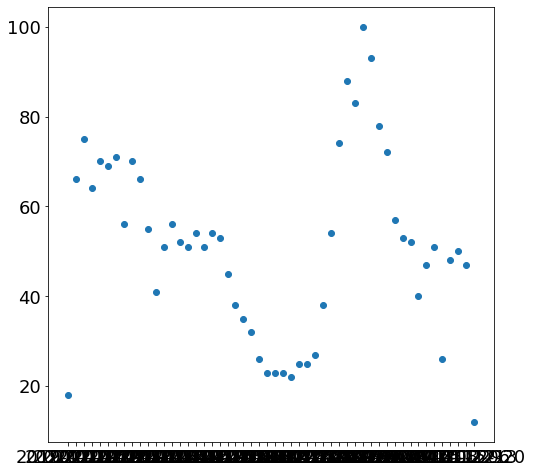

In [9]:
table = 'algebra_google_trends.csv'
original_table = pd.read_csv(table, header = 1).rename(columns={"algebra: (United States)": "US Algebra Searches"})
pd_labels = list(original_table.columns)
print(original_table.head())
plt.scatter(original_table.Week, original_table.loc[:, 'US Algebra Searches']);

In [10]:
algebra_tbl = Table().with_columns(pd_labels[0], list(original_table.Week), 
                                 pd_labels[1], list(original_table.loc[:, pd_labels[1]]))
algebra_tbl = algebra_tbl.relabel('Week', 'Date by Week').with_column('Week', np.arange(algebra_tbl.num_rows) + 1)
print(algebra_tbl.row(algebra_tbl.num_rows - 1))
algebra_tbl

Row(Date by Week='2020-12-20', US Algebra Searches=12, Week=52)


Date by Week,US Algebra Searches,Week
2019-12-29,18,1
2020-01-05,66,2
2020-01-12,75,3
2020-01-19,64,4
2020-01-26,70,5
2020-02-02,69,6
2020-02-09,71,7
2020-02-16,56,8
2020-02-23,70,9
2020-03-01,66,10


Since the data captures the weekly trend of searches for $algebra$, we would like to use KNN Regression to predict the search rating. We must train our algorithm in order to make a prediction.

KNN Fitted Value: 44.4

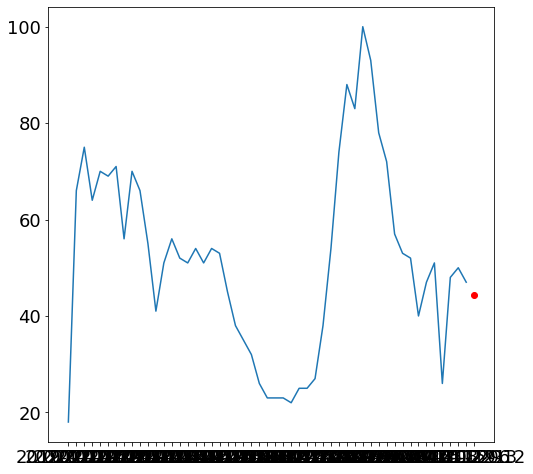

In [11]:
algebra_split = split_dataset(algebra_tbl.take(np.arange(51)))
algebra_train = train_table(algebra_split)
algebra_test = test_table(algebra_split)

algebra_features = algebra_tbl.select('Week').labels
algebra_regression_label = algebra_tbl.select("US Algebra Searches").labels[0]
algebra_regression_arr = algebra_test.column('US Algebra Searches')

unknown_algebra_trend = ['2020-19-12','?', 52] # Unknown Vector
predicted_val = knn_regression(unknown_algebra_trend[2], algebra_train, algebra_features, algebra_regression_label)
display(Markdown("KNN Fitted Value: {0}".format(predicted_val)))
plt.plot(algebra_tbl.column(0)[np.arange(51)], algebra_tbl.column(1)[np.arange(51)])
plt.scatter(unknown_algebra_trend[0], predicted_val, color='red');

## Projected Results Compared to  Google Trends
The KNN Algorithm shows some promise regarding the accuracy of the value produced by Google Trends.

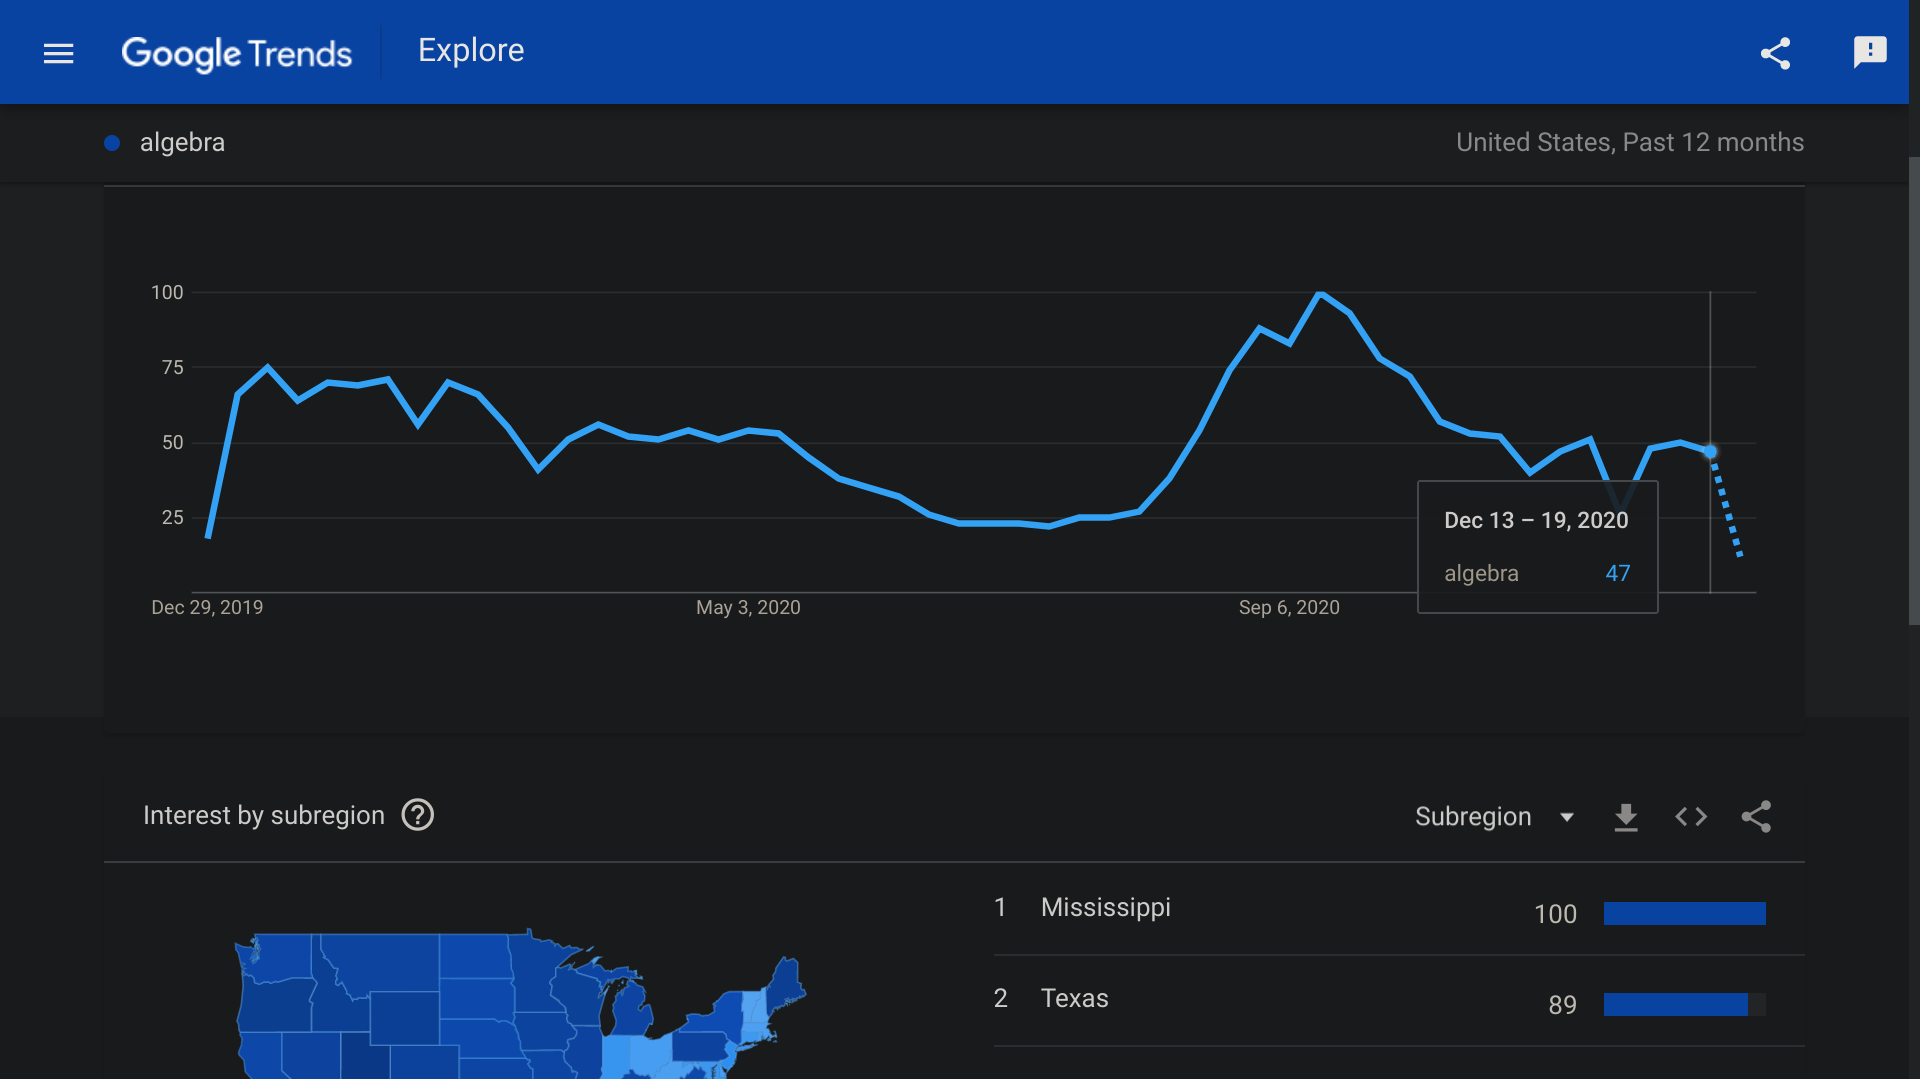

However, the initial value provided by the KNN Algorithm also is quite variable. By implementing the law of large numbers, the mean value will approach a more accurate representation of the fitted value produced by the algorithm. In this example, $50,000$ simulations were conducted.

In [12]:
simulated_results = make_array()
simulations = 50000
for simulation in np.arange(simulations):
    algebra_split = split_dataset(algebra_tbl)
    algebra_train = train_table(algebra_split)
    algebra_test = test_table(algebra_split)

    simulated_fitted_val = knn_regression(unknown_algebra_trend[2], algebra_train, algebra_features, algebra_regression_label)
    simulated_results = np.append(simulated_results, simulated_fitted_val)

Mean: 39.17
SD: 3.46


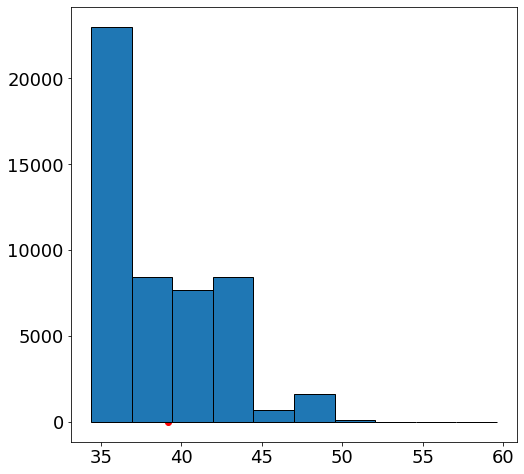

In [13]:
empirical_mean, empirical_std = np.mean(simulated_results), np.std(simulated_results)
print("Mean:", np.round(empirical_mean, 2))
print("SD:", np.round(empirical_std, 2))
plt.hist(simulated_results)
plt.scatter(empirical_mean, -0.91, color='red');

# Computational Efficiency: Chebyshev Theorem
> ## Note:
>>The implementation of the radius of convergence has not been correctly implemented at this point. Therefore, exploring the effects of Chebyshev's Theorem after the results that have been produced by the Nearest Neighbors Algorithm will be displayed instead.

In order to filter the results produced by the KNN Algorithm, applying Chebshev's Bounds will restrict the range of possible values the search trend value will be. It is important to note that Chebshev's Theorem does not impose any assumptions of the distribution displayed by the results from KNN. Since this is the case, changing the bounds will simply omit data values at the tail-ends of the data while preserving the values produced by KNN. 

The function implementation defaults to taking 50% of the data produced by KNN. The choice to take 50% helps with computation time, but 66% is the optimal percentage to preserve the properties of KNN.

In [14]:
def chebyshev_bounds(vector, desired_percent=0.5):
    """This function takes in an array and returns an arrray that has the interval
        determined by Chebyshev Inequality. 
        1 - 1/z^2 where sqrt(z^2) is the number of sds."""
    vector_mean, vector_sd = np.mean(vector), np.std(vector) 
    chebyshev_SD = np.round(np.sqrt(1 / (1 - desired_percent))) # formula algebraiclly manipulated
    SD_multiple = chebyshev_SD * vector_sd
    return [vector_mean - SD_multiple, vector_mean +SD_multiple]

# selectors
def get_lower_bound(lst):
    return lst[0]
def get_upper_bound(lst):
    return lst[1]

In [15]:
desired_data = 0.50
empirical_dist = chebyshev_bounds(simulated_results, desired_data)
rmse = compute_rmse(np.full(simulation + 1, 47), simulated_results)
display(Markdown("{0}% of the data falls within: [{1}, {2}]".format(desired_data * 100, 
                np.round(get_lower_bound(empirical_dist), 2), 
                np.round(get_upper_bound(empirical_dist), 2))))

display(Markdown("Root Mean Square Error of KNN Regression: {0}".format(rmse)))

50.0% of the data falls within: [35.72, 42.63]

Root Mean Square Error of KNN Regression: 8.557

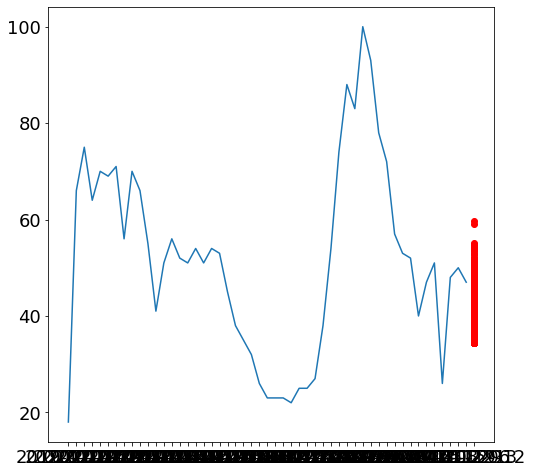

In [16]:
plt.plot(algebra_tbl.column(0)[np.arange(51)], algebra_tbl.column(1)[np.arange(51)])
plt.scatter(np.full(simulation + 1, unknown_algebra_trend[0]), simulated_results, color='red');

When bounding the results from the KNN Algorithm, 50% of the results are preserved. Thus, the range of potential values representing the search popularity of "Algebra" is narrowed.

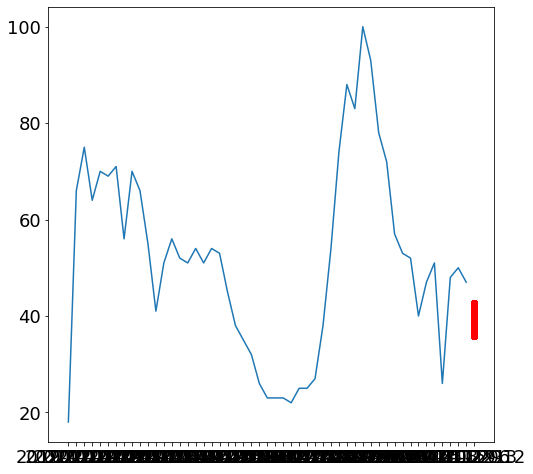

In [17]:
constrained_values = np.where(np.logical_and(simulated_results >= empirical_dist[0], simulated_results <= empirical_dist[1]))
plt.plot(algebra_tbl.column(0)[np.arange(51)], algebra_tbl.column(1)[np.arange(51)])
plt.scatter(np.full(len(constrained_values[0]), unknown_algebra_trend[0]), simulated_results[constrained_values], color='red');                           

After implementing Chebyshev's Theorem to take 50% of the results produced by the KNN Algorithm, the graph below displays the difference in bounds that contain the search trend value for "Algebra."

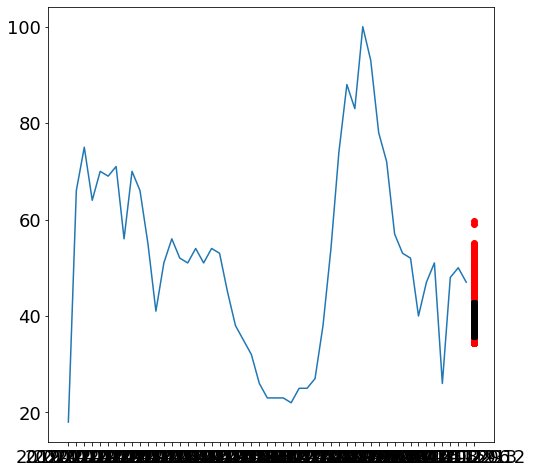

In [18]:
plt.plot(algebra_tbl.column(0)[np.arange(51)], algebra_tbl.column(1)[np.arange(51)])
plt.scatter(np.full(simulation + 1, unknown_algebra_trend[0]), simulated_results, color='red');
plt.scatter(np.full(len(constrained_values[0]), unknown_algebra_trend[0]), simulated_results[constrained_values], color='black');

# Conclusion

Unfortunately, the implementation of bounding the machine learning algorithm into a radius of convergence is not completed at this point of the project. However, in order to observe the result of applying Chebyshev's Theorem the results of the filtered potential search trend values can be observed when filtering the results. It is important to note that this is not a 1:1 demonstration of bounding the algorithm since KNN had produced values without Chebyshev's Theorem. Thus, the error is introduced by filtering the results produced by the machine learning algorithm. 

## Update on Angular Weights 


When testing the accuracy of the cosine weights, the inner product should not be used as the default mathematical model since it will reduce the lower accuracy of the KNN algorithm. Thus, this function should be used sparingly only after results have been found with another function implementation to compute distance.  

## Non-binary Classification
This is not relevant in this implementation of the KNN algorithm. However, it is important to note that it is possible to create a binary classification by simply setting an inequality boundary. For example, say if that a health condition can be classified from 1 to 5, 1 being the least terminal and 5 being most chronic, instead of using KNN to identify each result into 5 different classifications, we can impose an inequality boundary such that if a person is classified less than 3, they are least chronic, and more than 3, more chronic. This first approach allows the KNN algorithm to classify objects easier.